In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from dystformer.patchtst.pipeline import PatchTSTPipeline

/stor/work/AMDG_Gilpin_Summer2024/miniconda3/envs/dystformer_jeff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pft_model = PatchTSTPipeline.from_pretrained(
    mode="predict",
    pretrain_path="/stor/work/AMDG_Gilpin_Summer2024/checkpoints/pft_fullyfeat_from_scratch_longer-0/checkpoint-final",
    device_map="cuda:0",
)

In [3]:
def get_attn_weights(model, key: str) -> list[dict[str, torch.Tensor]]:
    params = [
        {
            "Wq": getattr(l, key).q_proj.weight,
            "Wk": getattr(l, key).k_proj.weight,
            "Wv": getattr(l, key).v_proj.weight,
        }
        for l in model.model.model.encoder.layers  # lol
    ]
    return params


def get_attn_map(
    weights: list[dict[str, torch.Tensor]], index: int, shift: bool = False
) -> np.ndarray:
    attn_map = (weights[index]["Wq"] @ weights[index]["Wk"].T).detach().cpu().numpy()
    if shift:
        attn_map = (attn_map - np.min(attn_map)) / (np.max(attn_map) - np.min(attn_map))
    return attn_map


def symmetric_distance(attn_map: np.ndarray) -> float:
    return (
        0.5
        * np.linalg.norm(attn_map - attn_map.T, "fro")
        / np.linalg.norm(attn_map, "fro")
    )


In [4]:
temporal_weights = get_attn_weights(pft_model, "temporal_self_attn")
channel_weights = get_attn_weights(pft_model, "channel_self_attn")

0.6707832246580251


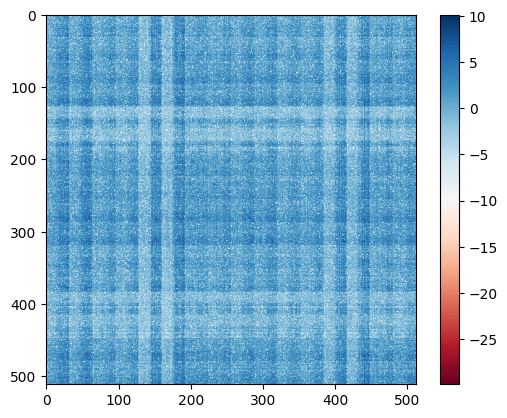

In [5]:
attn_map = get_attn_map(temporal_weights, 0)
print(symmetric_distance(attn_map))
plt.figure()
plt.imshow(np.log(attn_map**2), cmap="RdBu")
plt.colorbar()
plt.show()

0.5162998456573482


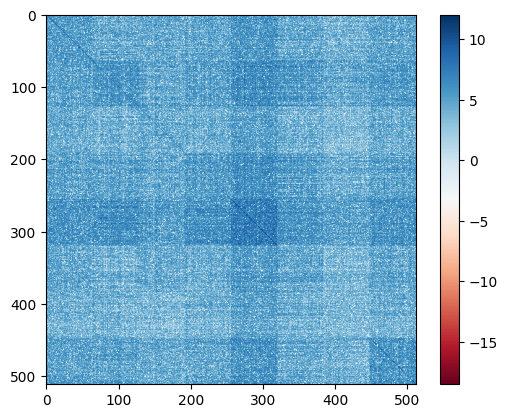

In [6]:
attn_map = get_attn_map(channel_weights, 0)
print(symmetric_distance(attn_map))
plt.figure()
plt.imshow(np.log(attn_map**2), cmap="RdBu")
plt.colorbar()
plt.show()

Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): GELUActivation()
  (2): Identity()
  (3): Linear(in_features=512, out_features=512, bias=True)
)
0.705630672934778


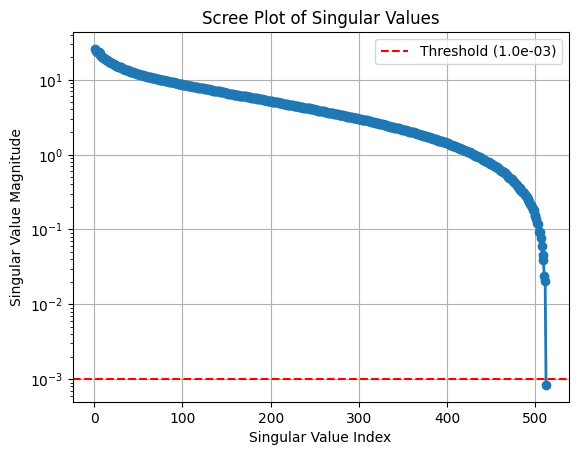

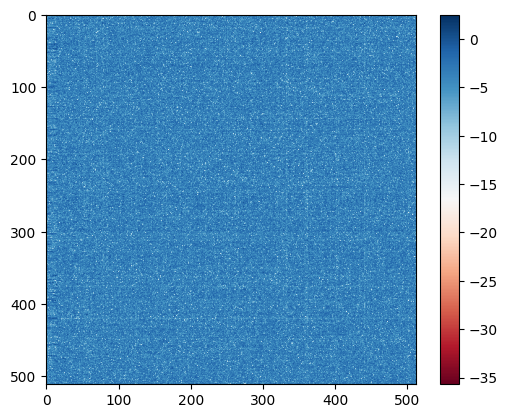

In [7]:
llayer = pft_model.model.model.encoder.layers[0].ff
print(llayer)
ffw = llayer[0].weight.detach().cpu().numpy()
print(symmetric_distance(ffw))

U, S, V = np.linalg.svd(ffw)
threshold = 1e-3
rank = np.sum(S > threshold)
plt.figure()
plt.plot(range(1, len(S) + 1), S, "o-", linewidth=2)
plt.title("Scree Plot of Singular Values")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value Magnitude")
plt.grid(True)
plt.yscale("log")  # Log scale to better visualize the decay
plt.axhline(
    y=threshold, color="r", linestyle="--", label=f"Threshold ({threshold:.1e})"
)
plt.legend()
plt.show()

reconstructed = U[:, :rank] @ np.diag(S)[:rank, :rank] @ V[:rank, :]
plt.figure()
plt.imshow(np.log(reconstructed**2), cmap="RdBu")
plt.colorbar()
plt.show()

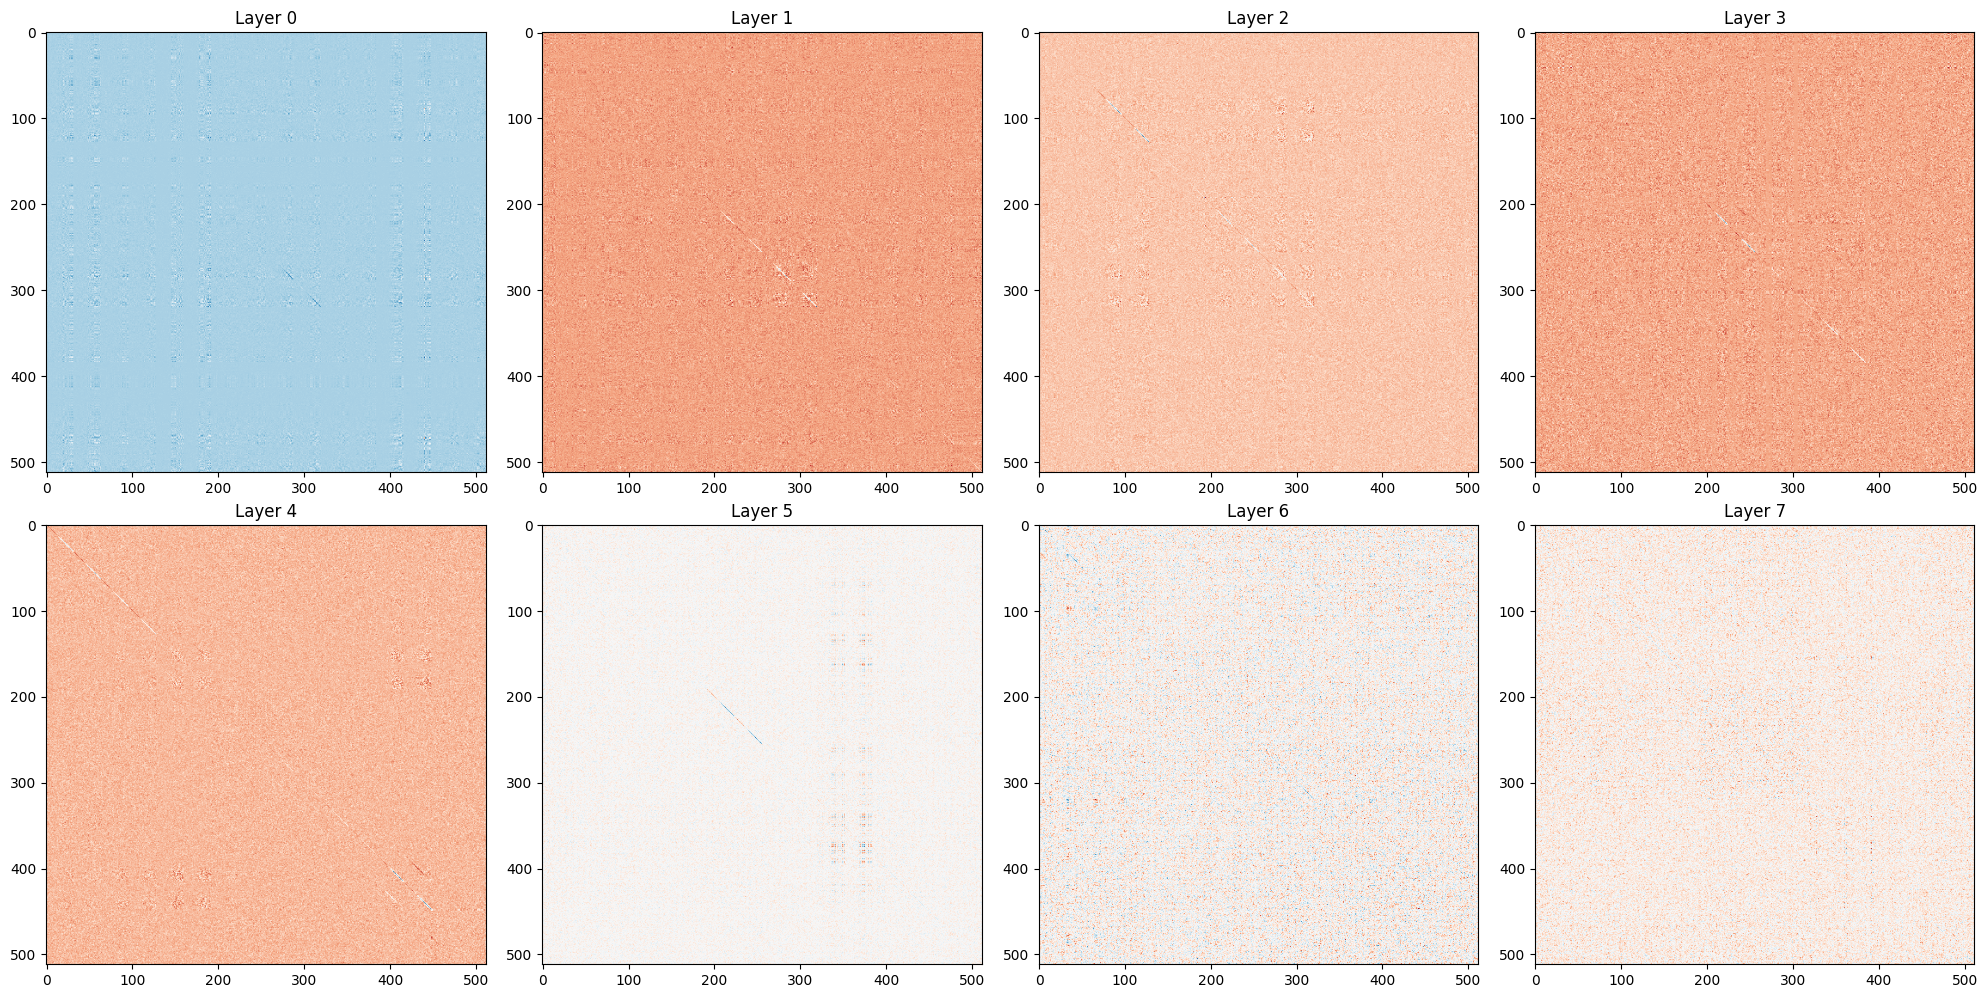

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    attn_map = get_attn_map(temporal_weights, i)
    ax.imshow(attn_map, cmap="RdBu")
    ax.set_title(f"Layer {i}")
plt.tight_layout()
plt.show()


In [182]:
import os
from pathlib import Path

from gluonts.dataset.common import FileDataset

# get train data paths
test_data_dirs = ["/stor/work/AMDG_Gilpin_Summer2024/data/final_base80/train/Lorenz"]
test_data_paths = []
for test_data_dir in test_data_dirs:
    test_data_dir = os.path.expandvars(test_data_dir)
    test_data_paths.extend(
        filter(lambda file: file.is_file(), Path(test_data_dir).rglob("*"))
    )
print(test_data_paths)

system_idx = 0
dataset = FileDataset(
    path=test_data_paths[system_idx],
    freq="h",
    one_dim_target=False,
)
trajectory = next(iter(dataset))["target"]


[PosixPath('/stor/work/AMDG_Gilpin_Summer2024/data/final_base80/train/Lorenz/90_T-4096.arrow'), PosixPath('/stor/work/AMDG_Gilpin_Summer2024/data/final_base80/train/Lorenz/189_T-4096.arrow'), PosixPath('/stor/work/AMDG_Gilpin_Summer2024/data/final_base80/train/Lorenz/36_T-4096.arrow'), PosixPath('/stor/work/AMDG_Gilpin_Summer2024/data/final_base80/train/Lorenz/104_T-4096.arrow'), PosixPath('/stor/work/AMDG_Gilpin_Summer2024/data/final_base80/train/Lorenz/188_T-4096.arrow'), PosixPath('/stor/work/AMDG_Gilpin_Summer2024/data/final_base80/train/Lorenz/91_T-4096.arrow'), PosixPath('/stor/work/AMDG_Gilpin_Summer2024/data/final_base80/train/Lorenz/155_T-4096.arrow'), PosixPath('/stor/work/AMDG_Gilpin_Summer2024/data/final_base80/train/Lorenz/106_T-4096.arrow'), PosixPath('/stor/work/AMDG_Gilpin_Summer2024/data/final_base80/train/Lorenz/93_T-4096.arrow'), PosixPath('/stor/work/AMDG_Gilpin_Summer2024/data/final_base80/train/Lorenz/67_T-4096.arrow'), PosixPath('/stor/work/AMDG_Gilpin_Summer2024

In [183]:
def plot_attn_map(
    model,
    context: np.ndarray,
    patch_size: int,
    sample_idx: int,
    layer_idx: int,
    head_idx: int,
    prefix: str = "",
) -> None:
    """Plot attention matrix with corresponding timeseries patches along edges."""
    attention_type = "temporal" if layer_idx % 2 == 0 else "channel"
    patches = context.reshape(context.shape[0], -1, patch_size)
    if attention_type == "channel":
        patches = patches.transpose(1, 0, 2)

    context_tensor = torch.from_numpy(context.T).float().to(pft_model.device)[None, ...]
    pred = model(context_tensor, output_attentions=True)
    attn_weights = pred.attentions

    # Extract attention weights for specified sample, layer and head
    num_samples = attn_weights[layer_idx].shape[0]
    attn = attn_weights[layer_idx][sample_idx, head_idx].detach().cpu().numpy()
    n_patches = attn.shape[0]

    # Create figure with gridspec layout
    fig = plt.figure(figsize=(10, 10))

    # Create main grid with padding for colorbar
    outer_grid = fig.add_gridspec(1, 2, width_ratios=[1, 0.05], wspace=0.05)

    # Create sub-grid for the plots
    gs = outer_grid[0].subgridspec(
        2, 2, width_ratios=[0.15, 0.85], height_ratios=[0.15, 0.85], wspace=0, hspace=0
    )

    # Plot attention matrix first to get its size
    ax_main = fig.add_subplot(gs[1, 1])
    im = ax_main.imshow(attn, extent=(0, n_patches, n_patches, 0))
    ax_main.set_xticks([])
    ax_main.set_yticks([])

    # Plot patches along top
    ax_top = fig.add_subplot(gs[0, 1])
    for i in range(n_patches):
        x = np.linspace(i, i + 1, patch_size)
        ax_top.plot(x, patches[sample_idx, i], linewidth=1)
    ax_top.set_xlim(0, n_patches)
    ax_top.set_xticks([])
    ax_top.set_yticks([])
    ax_top.grid(True)

    # Plot patches along left side
    ax_left = fig.add_subplot(gs[1, 0])
    for i in range(n_patches):
        y = np.linspace(i, i + 1, patch_size)
        ax_left.plot(-patches[sample_idx, i], y, linewidth=1)
    ax_left.set_ylim(n_patches, 0)
    ax_left.set_xticks([])
    ax_left.set_yticks([])
    ax_left.grid(True)

    # Add colorbar
    ax_cbar = fig.add_subplot(outer_grid[1])
    plt.colorbar(im, cax=ax_cbar)

    # Remove empty subplot
    fig.delaxes(fig.add_subplot(gs[0, 0]))

    # Force exact alignment of subplots
    main_pos = ax_main.get_position()
    ax_top.set_position(
        [main_pos.x0, main_pos.y1, main_pos.width, ax_top.get_position().height]
    )
    ax_left.set_position(
        [
            ax_left.get_position().x0,
            main_pos.y0,
            ax_left.get_position().width,
            main_pos.height,
        ]
    )
    ax_cbar.set_position(
        [
            ax_cbar.get_position().x0,
            main_pos.y0,
            ax_cbar.get_position().width,
            main_pos.height,
        ]
    )
    sample_type = "channel" if attention_type == "temporal" else "patch"
    ax_top.set_title(
        f"{prefix}{attention_type} attention @ layer {layer_idx}, head {head_idx}, ({sample_type} {sample_idx + 1}/{num_samples})"
    )
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_3452997/3322822569.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


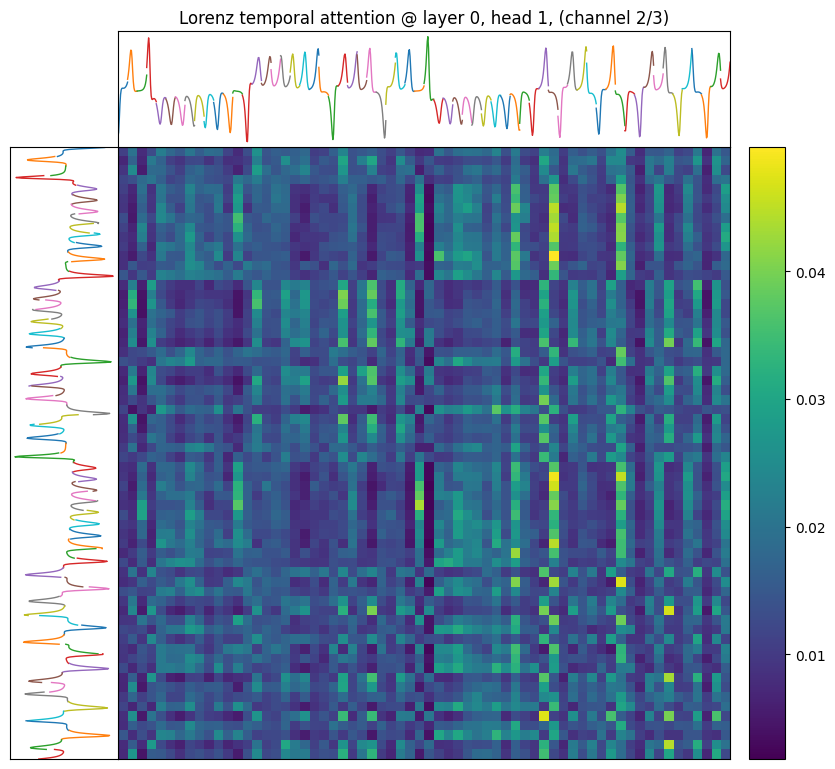

In [187]:
plot_attn_map(
    pft_model.model,
    trajectory[:, :1024],
    16,
    sample_idx=1,
    layer_idx=0,
    head_idx=1,
    prefix=test_data_paths[system_idx].parent.stem + " ",
)
